# Graph Classification with Topological Data Analysis Using Giotto-tda
### Author: Masakazu Yamagiwa

## 1. Introduction

### Graphs are useful for describing not only relationships and connections, but also the shapes of physical objects such as roads and bridges.  Historically, it can be said that both graph theory and topology find their roots in the mathematical problem known as the Seven Bridges of Königsberg.  Modern advances in theory and technology have made it possible to computationally study the geometric features of graphs.  For example, a graph convolutional network can be used to classify graphs, but can also be computationally expensive.  It is then of interest to study how the structure of graphs can be extracted using topological data analysis, which in turn can be used with a relatively light-weight machine learning model to classify its shape.  

### In this notebook, a toy dataset containing 8 types of regular graphs is classified with topological data analysis and a machine learning model.  Giotto-tda is used to obtain the topological features of each graph, which are fed into a random forest classifier.  For comparison, a rudimentary featurization method is introduced.

## 2. The Dataset

### The dataset used here is generated by [the Deep Graph Library (DGL)](https://www.dgl.ai/).  An auxiliary python file accompanying this notebook ('dgl_generator.py') calls a GDL method producing 1200 directed graphs and their labels.  The graphs are then converted to their adjacency matrices via [the NetworkX library](https://networkx.org/).  Finally, the adjacency matrices and their labels are both written to an HDF5 file ('GDataset.h5'), which also accompanies this notebook.

### The dataset contains 8 regular graphs as described in [this blog](https://www.dgl.ai/blog/2019/01/25/batch.html).  Some graphs, such as the cycle and wheel graphs, appear to have different topological characteristics while others, such as the lollipop and complete graphs, appear to have similar characteristics.

## 3. Analysis

### 3.1. Load libraries

In [90]:
# Install pip packages in the current Jupyter kernel
import sys
!{sys.executable} -m pip install numpy scipy h5py networkx

# data preprocessing
import numpy as np
from scipy import sparse
import h5py
import networkx as nx

# vizualization
import matplotlib.pyplot as plt
import plotly.io as pio
pio.orca.config.default_format = 'svg'

# tda tools
from gtda.graphs import GraphGeodesicDistance
from gtda.homology import VietorisRipsPersistence, FlagserPersistence
from gtda.diagrams import PersistenceEntropy, HeatKernel, PersistenceImage, Amplitude, PersistenceLandscape, BettiCurve, Silhouette
 
# machine learning tools
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

### 3.2. Load dataset

In [91]:
input_file = 'GDataset.h5'
h5file = h5py.File(input_file, 'r')

### 3.3. Load and preprocess dataset

#### The sparse matrix of each adjacency matrix is calculated and loaded to a list.  The labels are also loaded to a separate list.

In [92]:
adj_td_graph = []
adj_td = []
labels = []

for i in range(1200):
    folder = 'index_'  + str(i)
    adj_td_graph.append(h5file[folder + '/adjacency_matrix'][()])
    adj_td.append(sparse.csr_matrix(h5file[folder + '/adjacency_matrix'][()]))
    labels.append(h5file[folder + '/label'][()])

#### A rudimentary featurization method is applied to the adjacency matrix for comparison.  In this method, the adjacency matrix is flattend to a 1D vector, and padded with 0's at the end of the vector to match the length of the longest vector in the dataset.

In [93]:
maximum = 0
adj = []
labels_adj = []

for i in range(1200):
    folder = 'index_'  + str(i)
    max_length = max(len(h5file[folder + '/adjacency_matrix'][()]), maximum)
    maximum = max_length

for i in range(1200):
    folder = 'index_'  + str(i)
    length = len(h5file[folder + '/adjacency_matrix'][()])
    val = h5file[folder + '/adjacency_matrix'][()]
    adj.append(np.pad(val, [0, maximum - length], 'constant').reshape(maximum**2))
    labels_adj.append(h5file[folder + '/label'][()])

### 3.4. A visual introduction to the dataset, and feature extraction using Giotto-tda

#### A sample from each label in the dataset is shown, along with its persistence diagram information.  The sparse matrix of the adjacency matrix is processed using the GraphGeodesicDistance and FlagserPersistence methods provided by the Giotto-tda library.  The feature extraction method displayed here is the Betti curve of the persistence diagram.  The Betti curves (both H0 and H1) representation was adopted among all that was available, as it presented the richest feature from the persistence diagram.  This can be intuitively understood as the zero-th Betti number represents the number of connected components, while the first Betti number includes information about the number of edges and vertices, thus encompassing much of the information describing the graph.

In [96]:
def plot_graph(adjacency, label):
    """
    Show feature information, plot a graph from the adjacency matrix, 
    and print the label and persistence diagram information.
    """
    GGD = GraphGeodesicDistance(directed=True, unweighted=True)
    FP = FlagserPersistence()
    VR = VietorisRipsPersistence(metric="precomputed", infinity_values=10)
    AM = Amplitude()
    BC = BettiCurve()
    HK = HeatKernel()
    PE = PersistenceEntropy()
    PI = PersistenceImage()
    PL = PersistenceLandscape()
    SI = Silhouette()
    
    smatrix = sparse.csr_matrix(adjacency)
    
    X_ggd = GGD.fit_transform([smatrix])
    diagrams = FP.fit_transform(X_ggd)
#    feature1 = AM.fit_transform(diagrams)
    feature2 = BC.fit_transform(diagrams)
#    feature3 = HK.fit_transform_plot(diagrams)
#    feature4 = PE.fit_transform(diagrams)
#    feature5 = PI.fit_transform_plot(diagrams)
##    feature6 = PL.fit_transform_plot(diagrams)
#    feature7 = SI.fit_transform_plot(diagrams)
    
    graph = nx.from_numpy_matrix(adjacency, create_using=nx.DiGraph)
    nx.draw(graph, edge_color = 'b', arrowsize=15, node_size=20, alpha=0.5, arrows=True)
    plt.show()
    
    return (f"features: {feature2}, label: {label}, diagrams.shape: {diagrams.shape} ({diagrams.shape[1]} topological features)")

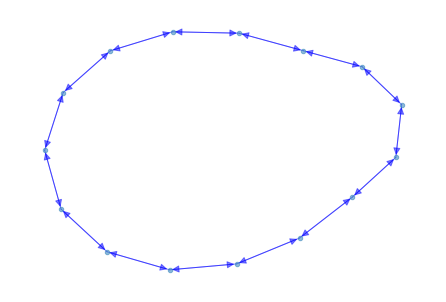

'features: [[[14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14\n   14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14\n   14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14\n   14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14\n   14 14 14 14 14 14 14  0]\n  [16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16\n   16 16  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1\n    1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1\n    1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1\n    1  1  1  1  1  1  1  0]]], label: 0, diagrams.shape: (1, 30, 3) (30 topological features)'

In [97]:
plot_graph(adj_td_graph[0], labels[0])

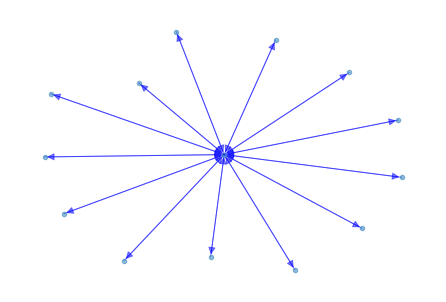

'features: [[[13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13\n   13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13\n   13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13\n   13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13\n   13 13 13 13 13 13 13  0]\n  [13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13\n   13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13\n   13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13\n   13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13\n   13 13 13 13 13 13 13  0]]], label: 1, diagrams.shape: (1, 26, 3) (26 topological features)'

In [98]:
plot_graph(adj_td_graph[150], labels[150])

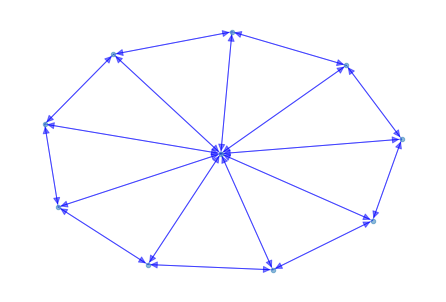

'features: [[[9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9\n   9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9\n   9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 0]\n  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0\n   0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0\n   0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]], label: 2, diagrams.shape: (1, 10, 3) (10 topological features)'

In [99]:
plot_graph(adj_td_graph[300], labels[300])

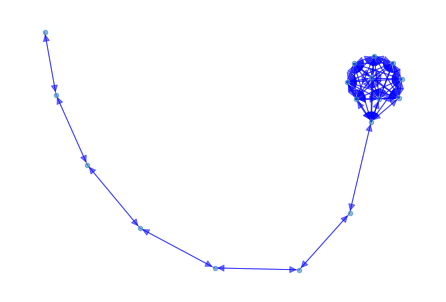

'features: [[[16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16\n   16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16\n   16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16\n   16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16\n   16 16 16 16 16 16 16  0]\n  [ 7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7\n    7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7\n    7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7\n    7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7\n    7  7  7  7  7  7  7  0]]], label: 3, diagrams.shape: (1, 23, 3) (23 topological features)'

In [100]:
plot_graph(adj_td_graph[450], labels[450])

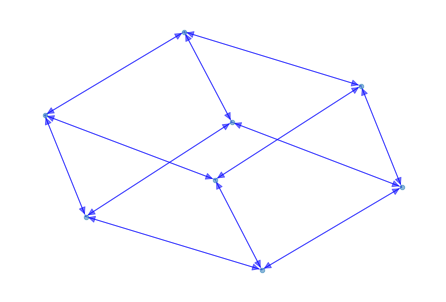

'features: [[[ 7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7\n    7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7\n    7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7\n    7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7\n    7  7  7  7  7  7  7  0]\n  [17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17\n   17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17\n   17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17\n   17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17\n   17 17 17 17 17 17 17  0]]], label: 4, diagrams.shape: (1, 24, 3) (24 topological features)'

In [101]:
plot_graph(adj_td_graph[600], labels[600])

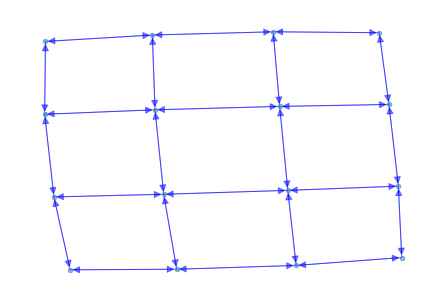

'features: [[[15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15\n   15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15\n   15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15\n   15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15\n   15 15 15 15 15 15 15  0]\n  [33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33\n   33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33\n   33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33\n   33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33 33\n   33 33 33 33 33 33 33  0]]], label: 5, diagrams.shape: (1, 48, 3) (48 topological features)'

In [102]:
plot_graph(adj_td_graph[750], labels[750])

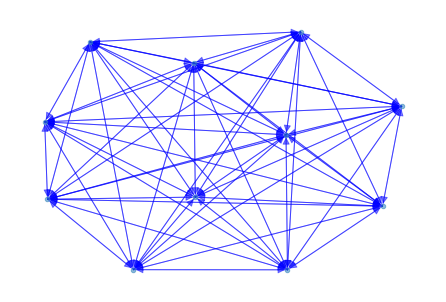

'features: [[[10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10\n   10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10\n   10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10\n   10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10\n   10 10 10 10 10 10 10  0]\n  [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0\n    0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0\n    0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0\n    0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0\n    0  0  0  0  0  0  0  0]]], label: 6, diagrams.shape: (1, 11, 3) (11 topological features)'

In [103]:
plot_graph(adj_td_graph[900], labels[900])

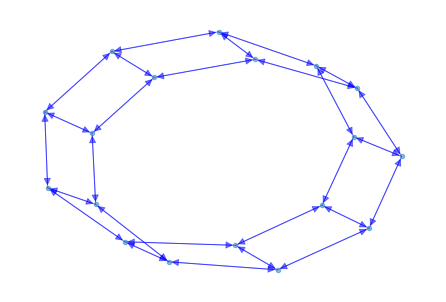

'features: [[[17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17\n   17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17\n   17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17\n   17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17 17\n   17 17 17 17 17 17 17  0]\n  [37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37\n   37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37 37\n   37 37 37 37  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1\n    1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1\n    1  1  1  1  1  1  1  0]]], label: 7, diagrams.shape: (1, 54, 3) (54 topological features)'

In [104]:
plot_graph(adj_td_graph[1100], labels[1100])

#### Graphs with similar shape have similar Betti curves.  For example, the graph labeled '0' shows Betti curve similar to that of the graph labeled '7', while both graph '0' and graph '7' share a circular shape.  The Betti numbers for each graph are different, however.  

### 3.5. Machine learning of labeled graphs using a random forest classifier

#### The Betti curves for both H0 and H1 are concatenated into one vector and are fed to a random forest classifier in the following steps.  The steps of the pipeline are the same as in the visualization above, again using the GraphGeodesicDistance, FlagserPersistence, and BettiCurve methods.  The resulting curves are concatenated with a feature concatenation function and finally used as features for a random forest classifier.  Note that the hyperparameters are not particularly optimized.  A single step consisting of another random forest classifier is also defined here for later comparison.

In [105]:
def feature_concat(X):
    """
    concatenate the features for Random Forest Classifier
    """
    
    XX = X.copy()
    XX = np.concatenate([XX[:, 0, :], XX[:, 1, :]], axis=1)
    return XX

In [106]:
steps = [     
    GraphGeodesicDistance(directed=True, unweighted=True),
    FlagserPersistence(),
    BettiCurve(),
    FunctionTransformer(feature_concat),
    RandomForestClassifier(random_state=0)]

steps_adj = [RandomForestClassifier(random_state=0)]

In [107]:
pipeline = make_pipeline(*steps)
pipeline_adj = make_pipeline(*steps_adj)

### 3.5.1. Splitting the dataset to train/test pairs

#### The dataset is split into train/test pairs with a training data size of 960 and a test data size of 240.

In [108]:
adj_td_train, adj_td_valid, labels_train, labels_valid = train_test_split(adj_td, labels, train_size=0.8)

### 3.5.2. Fitting the random forest classifier model with the training data

In [109]:
pipeline.fit(adj_td_train, labels_train)

Pipeline(steps=[('graphgeodesicdistance',
                 GraphGeodesicDistance(directed=True, unweighted=True)),
                ('flagserpersistence', FlagserPersistence()),
                ('betticurve', BettiCurve()),
                ('functiontransformer',
                 FunctionTransformer(func=<function feature_concat at 0x000001E7E8DC7CA0>)),
                ('randomforestclassifier',
                 RandomForestClassifier(random_state=0))])

### 3.5.3. Scoring the random forest classifier model with the test data

#### The trained model is evaluated with the withheld test data.  An accuracy of approximately 84% to 89% is achieved.  This value is comparable to the values reported on [the DGL blog](https://www.dgl.ai/blog/2019/01/25/batch.html), which states that the argmax accuracy can be as high as 91%.  It is interesting to note that this relatively high classification accuracy can be achieved with standard hardware requirements, a relatively simpler model, and shorter training time.

In [110]:
pipeline.score(adj_td_valid, labels_valid)

0.875

## 4. Short benchmark

### 4.1. Adjacency matrices as features

#### As a very simple benchmark, the adjacency matrix of each graph, padded with 0's to adjust for difference in matrix size, is used as a vector for input into a separate random forest classifier model.  The same kind of model as above is used here to show how the difference in features affects the accuracy score.  The dataset is again spit into train/test pairs with a training data size of 960 and a test data size of 240.  The accuracy of the model on the test data is very low, at approximately 11% to 15%.  This shows how the topological information extracted from the adjacency matrix of a graph is a key component in obtaining high classification accuracy.

In [111]:
adj_train, adj_valid, adj_labels_train, adj_labels_valid = train_test_split(adj, labels_adj, train_size=0.8)

In [112]:
pipeline_adj.fit(adj_train, adj_labels_train)

Pipeline(steps=[('randomforestclassifier',
                 RandomForestClassifier(random_state=0))])

In [113]:
pipeline_adj.score(adj_valid, labels_valid)

0.1